# Компоненты нелинейного процесса

Для процессов, в которых есть периодические составляющие, прогнозные модели на основе простой экстраполяции текущего состояния работают плохо. В правой части рисунка ({numref}`nonlinear_prognoz`), где данные (черные точки), представляющие собой синусоиду (темно-синяя линия) с шумом, закончились, видно, что регрессионная модель SVR (красная линия) не может прогнозировать продолжение колебаний, останавливаясь на некотором уровне.
Модели KRR и GPR (голубая и оранжевая линии) способны прогнозировать будущие колебания.
Модель GPR (Gaussian Process Regression) кроме среднего значения предсказывает дисперсию (область разброса) значений:
область наиболее вероятного появления данных с учётом шума показана полупрозрачным оранжевым поясом вокруг оранжевой линии.


::: {figure-md} nonlinear_prognoz
![](i/nonlinear_prognoz.png)

Сравнение различных моделей трендов. GPR - Gaussian Process Regression.
[&copy;](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Regressions_sine_demo.svg/1024px-Regressions_sine_demo.svg.png)
:::

In [1]:
%pylab inline
from ipywidgets import interact
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


Подберем параметры Гауссова процесса для данных в тесте ускорения нажатий.
Подставьте ссылку на собственные данные, если вы прошли тест по инструкции.

In [6]:
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as Constant, \
        Matern, PairwiseKernel, Exponentiation, RationalQuadratic

In [3]:
u='http://stireac.com/uskor/result.tsv/sherdim%40gmail.com/10.132.32.111__6158019760000190311'
M = pd.read_table(u)
M = M.rename(columns={'v':'code'})
M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1000 non-null   float64
 1   code    1000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


Извлечем из списка маркеров информацию о нажатиях с разбивкой по этапам.

In [4]:
R = []
for itrial in range(6):
    coab = (1000 + itrial)+1
    tab = M.t[M.code==coab].iloc[0]
    tad = M.t[(M.t>tab) & (M.code==13)].iloc[0]
    _R = M[(M.t>=tab)&(M.t<tad)].copy()
    _R['trial']=itrial+1
#     _R['d']=np.nan
    # оставляем только нажатия (коды отжатия < 0)
    _R = _R[(_R.code > 20) & (_R.code < 100)]
    # выравниваем по времени относительно начала этапа
    _R.t -= tab
    _R.dropna(inplace=True)
    _R['iri'] = _R.t.diff()
    
    R.append(_R)
    
R = pd.concat(R)
R.shape

(445, 4)

Этапы отличаются между собой порядком нажатия на кнопки F и J, коды которых маркируют моменты нажатия.

In [3]:
(ord('F'), ord('J'))

(70, 74)

In [5]:
R.groupby(['trial','code']).code.count()

trial  code
1      70      48
2      74      45
3      70      43
       74      43
4      70      48
       74      49
5      70      22
       74      62
6      70      60
       74      25
Name: code, dtype: int64

Создадим справочную таблицу с паттернами этапов.

In [ ]:
S = pd.DataFrame([
['00000000', 'одна рука'],
['11111111', 'одна рука'],
['10101010', 'поочередно'],
['01010101', 'поочередно'],
['01110111', 'паттерн'],
['10001000', 'паттерн'],
    ], columns=['pattern','тип'], index=arange(6)+1)
#S

## Рисунок с нелинейными трендами

Для построения рисунка мы для каждого этапа выводим исходные данные и накладываем на них в том же цвете модель (среднее и стандартное отклонение).

Данными, динамику которых мы моделируем, являются интервалы между нажатиями, которые рассчитываются в строке.

    vv = np.diff(tt)

Обученная модель Гауссова процесса хранится в переменной `gpor`.
Из объекта модели мы извлекаем ряд параметров, которые сводим в таблицу параметров `P`, которую выводим в конце.


,const,a,period,noise,LML,R2
label,,,,,,
00000000,0.001222,0.497643,11.969143,0.000298,98.296158,0.993221
11111111,0.483434,0.706720,10.677941,0.000237,86.502677,0.998162
10101010,0.274411,0.887480,18.219857,0.001319,134.393564,0.984961
01010101,0.003352,1.062370,34.062973,0.001981,142.929722,0.978169
01110111,0.003453,0.929588,24.105527,0.000766,138.942631,0.993141
10001000,0.640024,0.646241,13.025212,0.001462,120.531530,0.989695


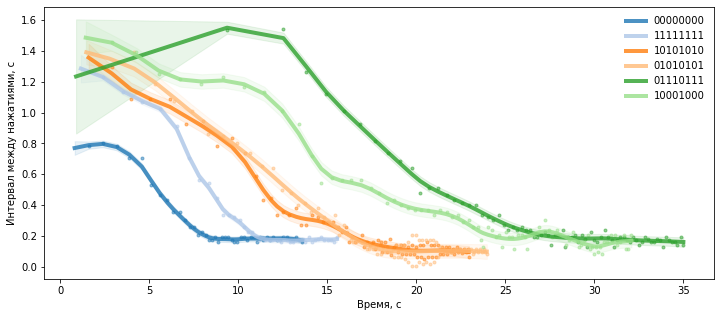

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

kernel = (Constant(1**2, (1e-6, 2.)) 
        + 0.05 * Matern(length_scale=20.0, length_scale_bounds=(3, 1e3), nu=1.5)
        + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e3))
         )
k = 1.

papa = []
coco = cm.tab20(arange(6))
for itrial, co in zip(arange(6)+1, coco):
    _R = R[R.trial==itrial]
        
    if len(_R)<5:
        continue
        
    tt = _R.t.values[1:] - _R.t.values[0]
    
    tt = tt[np.isfinite(tt)]
    vv = np.diff(tt) #_R.iri.values[1:]
    bb = vv < 1.6
    tt, vv = tt[np.r_[True, bb]], vv[bb]
    
    X = np.reshape(tt[1:],(-1,1))
    y = np.reshape(vv,(-1,1))
    gpor = GaussianProcessRegressor(kernel, alpha=1e-5, n_restarts_optimizer=0).fit(X, y)

    pa = {'label':S.loc[itrial, 'pattern']}
    pa['R2'] = gpor.score(X,y)
    pa['LML'] = gpor.log_marginal_likelihood_value_
    pa['n'] = len(vv)
    pa['totalvar'] = np.var(vv)
    _th = np.exp(gpor.kernel_.theta)
    pa['const'] = np.sqrt(_th[0])
    pa['a'] = np.sqrt(_th[1])
    pa['period'] = _th[2]
    pa['noise'] = _th[3]
    papa.append(pa)

    
    plot(tt[1:],vv,'.', color=co, alpha=.5, label='_nolegend_')

    xx = tt
    y_mean, y_std = gpor.predict(xx[:,np.newaxis], return_std=True)
    y_mean = y_mean.flatten()
    plt.plot(xx, y_mean, color=co, lw=4, alpha=.8, zorder=9, label=pa['label'])
    plt.fill_between(xx, y_mean - k * y_std, y_mean + k * y_std,
                     alpha=0.1, color=co)

plt.xlabel('Время, с');
plt.ylabel('Интервал между нажатиями, с');
# plt.ylim(0,1.2)
legend(frameon=False);
        
P = pd.DataFrame(papa)
P = P.set_index('label')
display(P[['const','a','period','noise', 'LML','R2']])

По параметру `period` можно сравнить выявленный колебательный компонент в с. Более пологий спуск соответствует более длительному периоду колебаний.

> Попробуйте поменять параметры регуляризации при обучении Гауссова процесса. Гиперпараметр `alpha`, по умолчанию равный 1e-10 (0.0000000001), нужен для предотвращения потенциальных вычислительных проблем во время подгонки модели.
Если его увеличить (сделать не таким ничтожным), то будут подобраны более плавные модели, не повторяющие столь подробно динамику процесса.
> Повышайте параметр `alpha` на порядок, начиная от 1e-3 до 1e0. Как изменяются параметры найденных моделей? В какой момент модели утрачивают способность описать переходный процесс? 
Игнорируйте предупреждения о проблемах сходимости модели.

*Гиперпараметр* - это параметр для управления процессом обучения по подбору других параметров.

## Прогноз

Воспользуемся уже рассмотренными ранее способами оценки качества прогноза для одного из этапов.

In [47]:
import matplotlib.animation as animation
rc('animation', html='jshtml')

In [4]:
def play_prognoz(k='prognoz', n_future = 1, k0='v', interval=500):

    xx=D.index.values
    tt= xx[:-1]

    fig = figure()
    xlim(0,len(D.index)+1); ylim(0,1.5);

    hh=[]
    hh.append( plot([],[], color='b', lw=0, marker='d')[0] )
    hh.append( plot(xx[0],D[k][0], color='r', marker='*')[0] ) #prognoz
    hh.append( vlines([],[],[], colors='pink') ) #residuals
    xlabel('Время, с');
    ylabel('Интервал между нажатиями, с');
    
    def updatefig(i):
        hh[0].set_data(xx[:i+1], D[k0][:i+1])
        hh[1].set_data(xx[[i,i+n_future]], D[k][[i,i+n_future]])
        res1=vstack([tile(xx[i],(2,)), [D.loc[i,k0],D.loc[i,k]]]).T
        hh[2].set_segments((hh[2].get_segments() + [res1]))
                            
        return hh

    close()
    ani = animation.FuncAnimation(fig, updatefig, tt, interval=interval, blit=True, repeat=False)
    return ani



Переменные `vv` и `y_mean` содержат данные и предсказания Гауссова процесса для последнего 6-го этапа. Организуем их в таблицу.

Добавим помимо подогнанной модели Гауссова процесса (не забудьте вернуть гиперпараметр в исходное состояние и получить качественные модели) несколько простых сглаживающих моделей.

In [ ]:
D = pd.DataFrame(vv, columns=['v'])#, index=tt[1:])

D['pro_gaupro'] = y_mean[1:]

D['pro_prev']= D.v.shift()
D['pro_median5']=D.v.rolling(5, min_periods=1).median().shift()
D['pro_mean5']=D.v.rolling(5, min_periods=1).mean().shift()
D['pro_ewma']=D.v.ewm(span=5, min_periods=1).mean().shift()

play_prognoz('pro_median5')

![](i/gaupro_median5.png)

In [ ]:
play_prognoz('pro_prev')

![](i/gaupro_prev.png)

In [38]:
def quo(k):
    '''чем больше отклонение - тем ниже эффективность'''
    return 1/sqrt(mean((D.v - D[k])**2))

# vidy = [_k for _k in D.columns if _k.startswith('pro_')]
vidy = ['pro_prev', 'pro_mean5', 'pro_median5', 'pro_ewma', 'pro_gaupro']
Q = pd.Series(map(quo, vidy), index=vidy)
Q


pro_prev       16.387643
pro_mean5       9.907941
pro_median5     9.497796
pro_ewma       10.681131
pro_gaupro     20.683305
dtype: float64

Прогноз по предыдущему значению имеет преимущество для резких переходных процессов, поскольку обладает минимальной "памятью" о прошлых значениях.

Компоненты процесса можно вычитать из общей динамики, и, таким образом, строить прогнозы с учетом разных сочетаний компонентов: медленных трендов, циклов, шума.